# Multi-Channel EGG Analysis: A Complete Pipeline Tutorial

This tutorial walks through the full analysis workflow for a multi-electrode
electrogastrography (EGG) recording. It builds on the single-channel
[EGG Processing Tutorial](egg_processing.ipynb) and demonstrates the
artefact-robust preprocessing methods introduced by Dalmaijer (2025).

**By the end of this tutorial you will be able to:**

1. Load and visualise a 7-channel EGG recording
2. Assess channel quality and select the optimal electrode
3. Apply spike removal, movement filtering, and bandpass cleaning
4. Compare the three multichannel strategies — `per_channel`,
   `best_channel`, and `ica`
5. Quantitatively compare outputs across methods with plots and tables
6. Fit a sine model to characterise the gastric oscillation

**Prerequisites:** [EGG Processing Tutorial](egg_processing.ipynb)

**Dataset:** 7-electrode EGG from Wolpert et al. (2020), sampled at
10 Hz (∼12.6 min, fasted state).

## Background

### Why use multiple electrodes?

A single surface electrode picks up a spatially averaged view of the gastric
slow wave (∼3 cpm / 0.05 Hz). Because the signal is small (∼50–500 µV at
the skin surface) and easily contaminated by cardiac, respiratory, and motion
artefacts, one electrode is often insufficient.

A multi-electrode array provides three complementary advantages:

| Strategy | Benefit |
|---|---|
| **Channel selection** | Pick the electrode with the strongest gastric-band power (reduces noise floor) |
| **Ensemble averaging** | Summarise metrics across all electrodes to get a more stable estimate |
| **Spatial denoising (ICA)** | Decompose correlated artefacts into independent components and remove them |

### Electrode placement (Wolpert 2020)

The bundled dataset uses a 7-electrode grid on the epigastric region.
The stomach projects most strongly to midline electrodes, but signal
quality varies by subject and recording condition.

### Processing pipeline overview

```
Raw multi-channel EGG
        │
        ▼
1. Visualise all channels — identify obvious problems
        │
        ▼
2. Channel quality assessment (Welch PSD → select best)
        │
        ▼
3. Artefact-robust preprocessing (Hampel + LMMSE + IIR)
        │
        ▼
4. Multichannel strategy: per_channel / best_channel / ica
        │
        ▼
5. Compare outputs → select for downstream analysis
        │
        ▼
6. Sine fitting for amplitude and phase characterisation
```

In [1]:
import warnings

import matplotlib.pyplot as plt
import numpy as np
from sklearn.exceptions import ConvergenceWarning

import gastropy as gp

plt.rcParams["figure.dpi"] = 100
plt.rcParams["figure.facecolor"] = "white"

print(f"GastroPy {gp.__version__}")

GastroPy 0.1.0


In [2]:
egg      = gp.load_egg()
signal   = egg["signal"]           # (7, n_samples)
sfreq    = egg["sfreq"]            # 10.0 Hz
ch_names = list(egg["ch_names"])
times    = np.arange(signal.shape[1]) / sfreq

print(f"Source   : {egg['source']}")
print(f"Channels : {signal.shape[0]}  ({ch_names})")
print(f"Samples  : {signal.shape[1]}  ({signal.shape[1]/sfreq:.0f} s,  "
      f"{signal.shape[1]/sfreq/60:.1f} min)")
print(f"Fs       : {sfreq} Hz")

Source   : wolpert_2020
Channels : 7  ([np.str_('EGG1'), np.str_('EGG2'), np.str_('EGG3'), np.str_('EGG4'), np.str_('EGG5'), np.str_('EGG6'), np.str_('EGG7')])
Samples  : 7580  (758 s,  12.6 min)
Fs       : 10.0 Hz


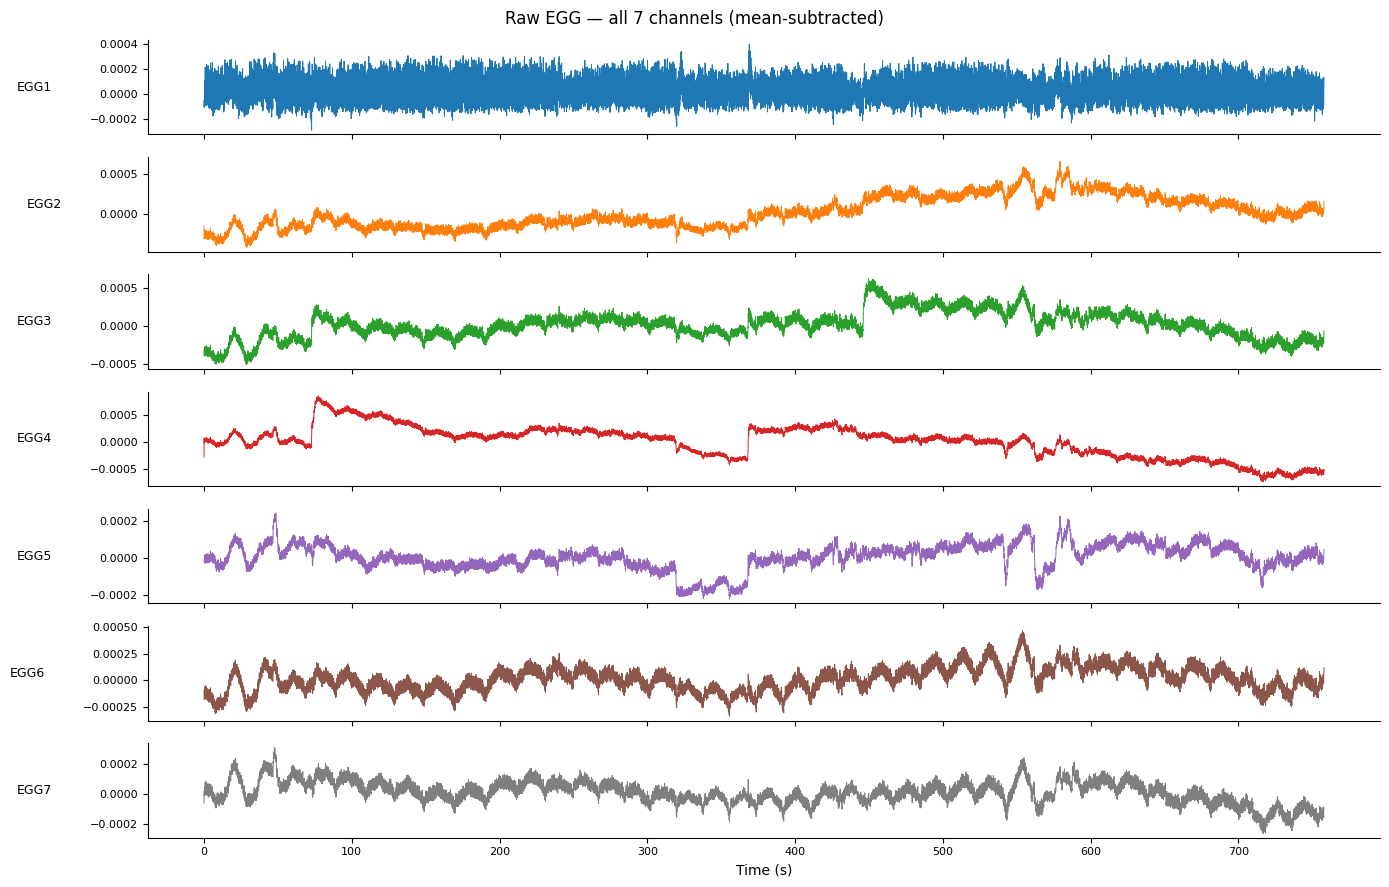

In [3]:
n_ch   = signal.shape[0]
colors = plt.cm.tab10(np.linspace(0, 0.7, n_ch))

fig, axes = plt.subplots(n_ch, 1, figsize=(14, 9), sharex=True)

for ax, ch, name, color in zip(axes, signal, ch_names, colors):
    ax.plot(times, ch - ch.mean(), lw=0.7, color=color)
    ax.set_ylabel(name, rotation=0, labelpad=40, va="center", fontsize=9)
    ax.tick_params(labelsize=8)
    for spine in ("top", "right"):
        ax.spines[spine].set_visible(False)

axes[-1].set_xlabel("Time (s)")
fig.suptitle("Raw EGG — all 7 channels (mean-subtracted)", fontsize=12)
fig.tight_layout()
plt.show()

## 1. Channel Quality Assessment

Before processing, it is important to identify which electrodes carry a
reliable gastric signal. `select_best_channel` ranks channels by peak
power in the normogastric band (2–4 cpm) using the Welch PSD method,
following Wolpert et al. (2020).

**When does channel quality matter?**

- For `method="best_channel"`: the result depends entirely on this ranking.
- For `method="ica"`: high-quality channels provide better ICA mixing matrix
  estimates, reducing reconstruction artefacts.
- For any single-channel downstream step: always start from the best channel.

In [4]:
# Compute Welch PSD for all channels
psd_list  = []
freqs_all = None
for ch in signal:
    freqs_ch, psd_ch = gp.psd_welch(ch, sfreq)
    psd_list.append(psd_ch)
    freqs_all = freqs_ch
psd_matrix = np.array(psd_list)   # (n_channels, n_freqs)

# Select the best channel
best_idx, peak_freq_hz, _, _ = gp.select_best_channel(signal, sfreq)
best_signal = signal[best_idx]

print(f"Best channel  : {ch_names[best_idx]}  (index {best_idx})")
print(f"Peak frequency: {peak_freq_hz:.4f} Hz  ({peak_freq_hz * 60:.2f} cpm)")
print()
print("Per-channel peaks:")
for i, name in enumerate(ch_names):
    _, pf, _, _ = gp.select_best_channel(signal[i : i + 1], sfreq)
    marker = "  ← best" if i == best_idx else ""
    print(f"  {name}: {pf:.4f} Hz  ({pf * 60:.2f} cpm){marker}")

Best channel  : EGG6  (index 5)
Peak frequency: 0.0530 Hz  (3.18 cpm)

Per-channel peaks:
  EGG1: 0.0520 Hz  (3.12 cpm)
  EGG2: 0.0380 Hz  (2.28 cpm)
  EGG3: 0.0520 Hz  (3.12 cpm)
  EGG4: 0.0350 Hz  (2.10 cpm)
  EGG5: 0.0370 Hz  (2.22 cpm)
  EGG6: 0.0530 Hz  (3.18 cpm)  ← best
  EGG7: 0.0530 Hz  (3.18 cpm)


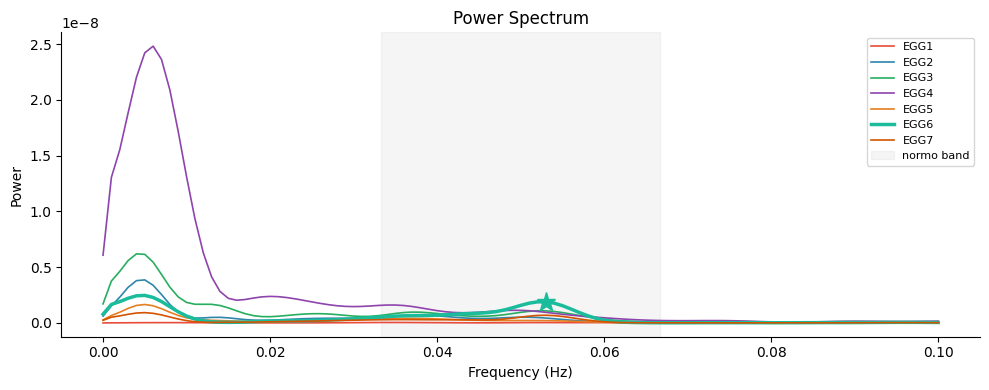

In [5]:
fig, ax = plt.subplots(figsize=(10, 4))
gp.plot_psd(freqs_all, psd_matrix, ch_names=ch_names, best_idx=best_idx,
            peak_freq=peak_freq_hz, ax=ax)
plt.tight_layout()
plt.show()

### Interpreting the PSD

The highlighted channel (**EGG6**) shows the clearest peak in the
normogastric band (shaded region). Several observations are typical of
multi-electrode EGG:

- **Signal variability across channels**: channels closer to the stomach
  antrum typically show stronger gastric peaks; lateral or cephalad
  electrodes may show attenuated or shifted peaks.
- **Low-frequency drift** (< 1 cpm): common in prolonged fasted recordings,
  usually due to respiration or electrode drift — removed by bandpass
  filtering.
- **Secondary peaks** at 2× the fundamental (≈ 6 cpm): harmonic content
  from the non-sinusoidal waveform shape of the gastric slow wave.

## 2. Artefact-Robust Preprocessing

Raw EGG signals often contain two types of non-physiological contamination
before bandpass filtering:

| Artefact type | Cause | Recommended filter |
|---|---|---|
| **Spike / transient** | Electrode movement, static discharge | `hampel_filter` |
| **Movement noise** | Breathing, posture shifts, ambulatory motion | `remove_movement_artifacts` |

GastroPy provides three named cleaning pipelines via `egg_clean`:

- `"fir"` *(default)* — zero-phase FIR bandpass only; assumes the signal
  is already artefact-free.
- `"iir"` — zero-phase IIR Butterworth bandpass; faster, slightly less
  sharp roll-off.
- `"dalmaijer2025"` — full Dalmaijer (2025) pipeline:
  **Hampel** → **LMMSE movement filter** → **IIR Butterworth**.
  Recommended for ambulatory recordings.

In this section we inject synthetic artefacts into the best channel and
compare how `"fir"` and `"dalmaijer2025"` handle them.

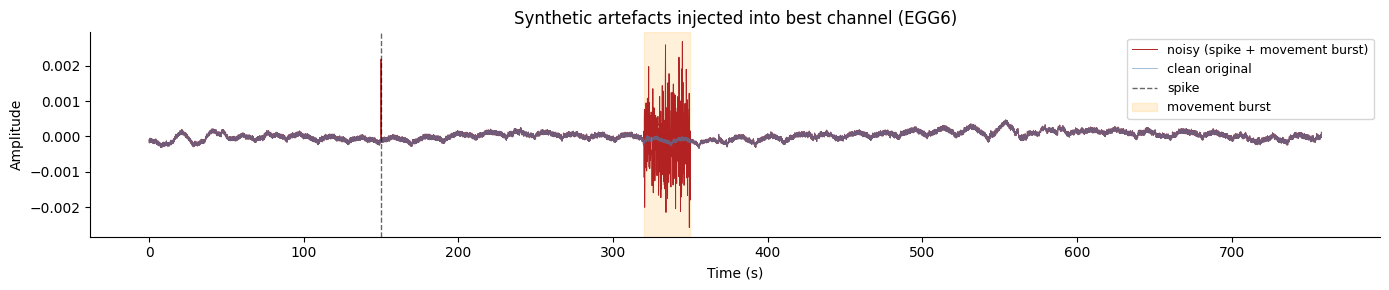

In [6]:
rng = np.random.default_rng(42)

noisy = best_signal.copy()

# Inject a large spike (isolated sample, 20× signal amplitude)
spike_idx = 1500
noisy[spike_idx] += 20 * np.std(best_signal)

# Inject a sustained movement burst (300 samples, 8× signal SD)
burst_start, burst_end = 3200, 3500
noisy[burst_start:burst_end] += 8 * np.std(best_signal) * rng.standard_normal(
    burst_end - burst_start
)

fig, ax = plt.subplots(figsize=(14, 3))
ax.plot(times, noisy - noisy.mean(), lw=0.7, color="firebrick",
        label="noisy (spike + movement burst)")
ax.plot(times, best_signal - best_signal.mean(), lw=0.6, color="steelblue",
        alpha=0.6, label="clean original")
ax.axvline(times[spike_idx], color="black", lw=1, ls="--", alpha=0.6, label="spike")
ax.axvspan(times[burst_start], times[burst_end], alpha=0.15, color="orange",
           label="movement burst")
ax.set_xlabel("Time (s)")
ax.set_ylabel("Amplitude")
ax.set_title("Synthetic artefacts injected into best channel (EGG6)")
ax.legend(fontsize=9)
for spine in ("top", "right"):
    ax.spines[spine].set_visible(False)
plt.tight_layout()
plt.show()

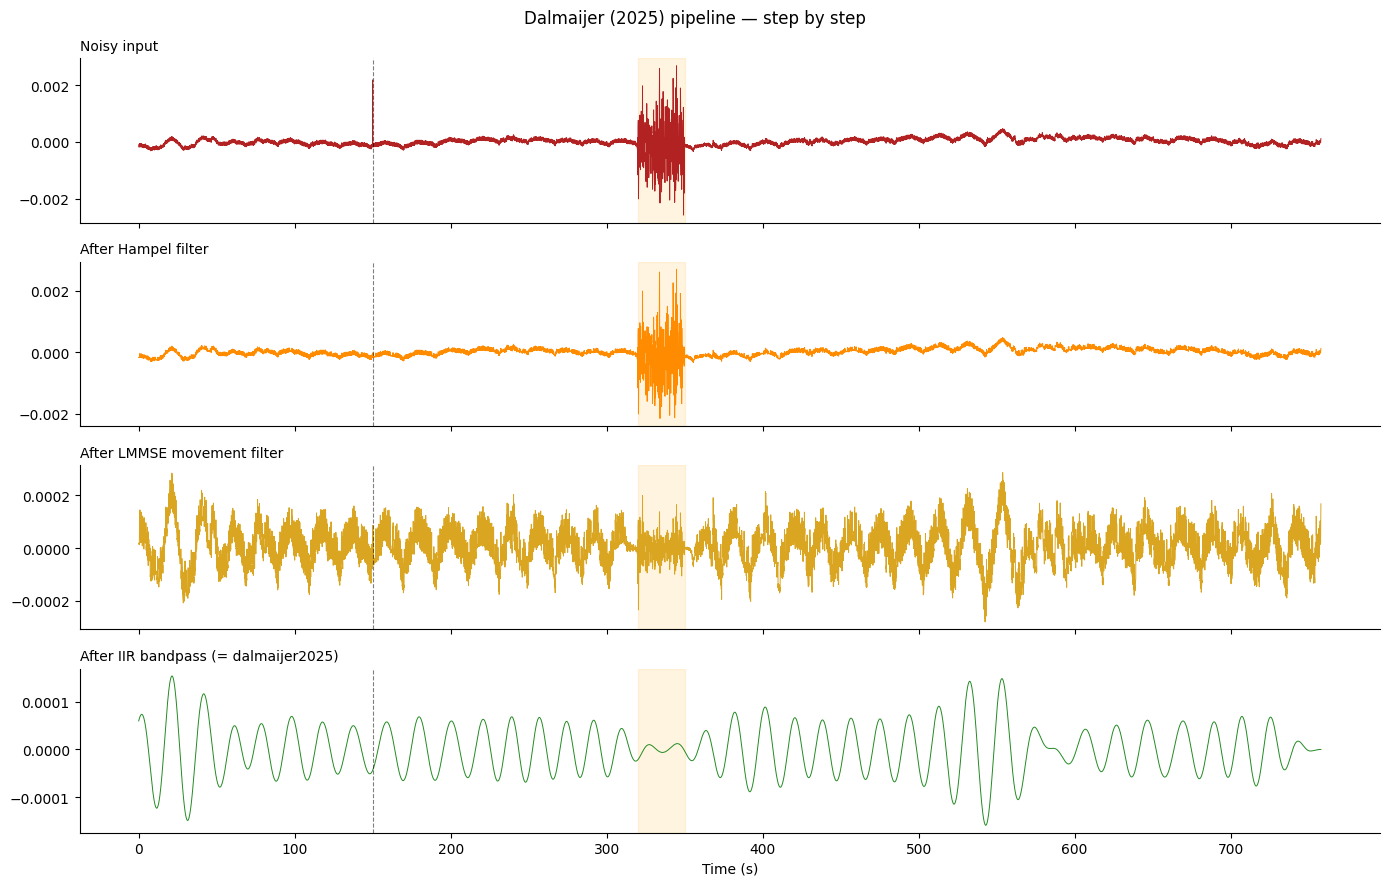

In [7]:
# Step 1: Hampel spike removal (local sliding-window median replacement)
after_hampel = gp.hampel_filter(noisy)

# Step 2: LMMSE movement filter (Gharibans et al. 2018)
after_movement = gp.remove_movement_artifacts(after_hampel, sfreq)

# Step 3: IIR Butterworth bandpass
after_bandpass, _ = gp.egg_clean(after_movement, sfreq, method="iir")

stages = [
    ("Noisy input", noisy, "firebrick"),
    ("After Hampel filter", after_hampel, "darkorange"),
    ("After LMMSE movement filter", after_movement, "goldenrod"),
    ("After IIR bandpass (= dalmaijer2025)", after_bandpass, "forestgreen"),
]

fig, axes = plt.subplots(len(stages), 1, figsize=(14, 9), sharex=True)
for ax, (title, sig, color) in zip(axes, stages):
    ax.plot(times, sig - sig.mean(), lw=0.7, color=color)
    ax.set_title(title, fontsize=10, loc="left")
    ax.axvline(times[spike_idx], color="black", lw=0.8, ls="--", alpha=0.5)
    ax.axvspan(times[burst_start], times[burst_end],
               alpha=0.12, color="orange")
    for spine in ("top", "right"):
        ax.spines[spine].set_visible(False)

axes[-1].set_xlabel("Time (s)")
fig.suptitle("Dalmaijer (2025) pipeline — step by step", fontsize=12)
fig.tight_layout()
plt.show()

FIR info     : {'filter_method': 'fir', 'fir_numtaps': 501, 'fir_window': 'hann', 'filtfilt_method': 'gust', 'cleaning_method': 'fir'}
D25 info     : {'cleaning_method': 'dalmaijer2025', 'hampel_k': 3, 'hampel_n_sigma': 3.0, 'movement_window': 1.0, 'freq_centre_hz': 0.049995, 'filter_method': 'iir_butter', 'butter_order': 4}


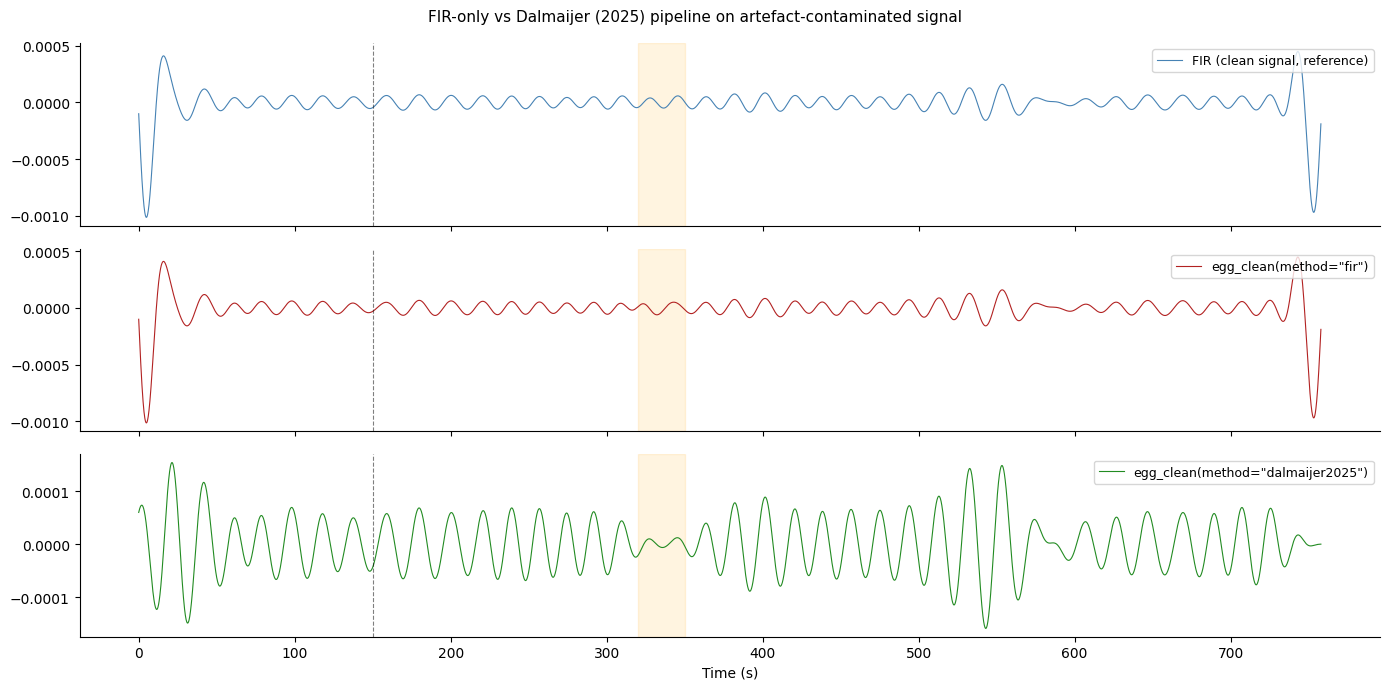

In [8]:
# Compare the two main cleaning approaches on the noisy signal
cleaned_fir, info_fir   = gp.egg_clean(noisy, sfreq, method="fir")
cleaned_d25, info_d25   = gp.egg_clean(noisy, sfreq, method="dalmaijer2025")
cleaned_orig, _         = gp.egg_clean(best_signal, sfreq, method="fir")  # reference

print("FIR info     :", {k: v for k, v in info_fir.items() if not isinstance(v, np.ndarray)})
print("D25 info     :", {k: v for k, v in info_d25.items() if not isinstance(v, np.ndarray)})

fig, axes = plt.subplots(3, 1, figsize=(14, 7), sharex=True)

axes[0].plot(times, cleaned_orig,  lw=0.8, color="steelblue",   label="FIR (clean signal, reference)")
axes[1].plot(times, cleaned_fir,   lw=0.8, color="firebrick",   label='egg_clean(method="fir")')
axes[2].plot(times, cleaned_d25,   lw=0.8, color="forestgreen", label='egg_clean(method="dalmaijer2025")')

for ax in axes:
    ax.axvline(times[spike_idx], color="black", lw=0.8, ls="--", alpha=0.5)
    ax.axvspan(times[burst_start], times[burst_end], alpha=0.12, color="orange")
    ax.legend(fontsize=9, loc="upper right")
    for spine in ("top", "right"):
        ax.spines[spine].set_visible(False)

axes[-1].set_xlabel("Time (s)")
fig.suptitle('FIR-only vs Dalmaijer (2025) pipeline on artefact-contaminated signal',
             fontsize=11)
fig.tight_layout()
plt.show()

### Which cleaning pipeline should you use?

| Scenario | Recommended `method` |
|---|---|
| Clean lab recording, no visible spikes or movement | `"fir"` (default) |
| Occasional electrode pops or transient spikes | `"fir"` + manual inspection, or `"dalmaijer2025"` |
| Ambulatory recording (walking, exercise) | `"dalmaijer2025"` |
| Real-time or iterative processing | `"iir"` |

> **Key observation from the plot above:** `method="fir"` passes the spike
> and movement burst through to the output (they are broadband and land
> partly inside the filter passband). `method="dalmaijer2025"` attenuates
> both, recovering a trace close to the clean reference.

## 3. Multichannel Processing Strategies

`egg_process_multichannel` applies one of three named strategies to a
`(n_channels, n_samples)` array. The strategies differ in how they
combine spatial information across electrodes:

| `method` | Spatial handling | Best for |
|---|---|---|
| `"per_channel"` | Independent; returns all-channel summary + best idx | Comparing electrodes; quality screening |
| `"best_channel"` | Select strongest channel; full `egg_process` on it | Single-channel metrics with automatic selection |
| `"ica"` | FastICA spatial denoising then per-channel | Noisy/ambulatory data; maximise SNR |

We will run all three on the **clean** real signal below, then compare their
outputs quantitatively.

In [9]:
result_per = gp.egg_process_multichannel(signal, sfreq, method="per_channel")

summary = result_per["summary"].copy()
summary.insert(1, "channel_name", ch_names)
print("per_channel summary:")
print(summary.to_string(index=False, float_format="{:.4g}".format))
print(f"\nBest channel (by band power): {ch_names[result_per['best_idx']]}  "
      f"(index {result_per['best_idx']})")

per_channel summary:
 channel channel_name  peak_freq_hz  instability_coefficient  proportion_normogastric  band_power_mean
       0         EGG1         0.052                   0.2115                   0.9211        2.388e-11
       1         EGG2         0.038                   0.3477                   0.8889        3.807e-10
       2         EGG3         0.052                   0.3595                   0.9143        6.718e-10
       3         EGG4         0.035                   0.1422                        1        8.955e-10
       4         EGG5         0.037                    1.408                    0.913        2.085e-10
       5         EGG6         0.053                   0.1759                   0.9459        8.264e-10
       6         EGG7         0.053                   0.7241                   0.9355        3.041e-10

Best channel (by band power): EGG4  (index 3)


In [10]:
result_best = gp.egg_process_multichannel(signal, sfreq, method="best_channel")

bi   = result_best["info"]["best_channel_idx"]
info = result_best["info"]
print(f"best_channel result:")
print(f"  Selected channel   : {ch_names[bi]}  (index {bi})")
print(f"  Peak frequency     : {info['peak_freq_hz']:.4f} Hz  "
      f"({info['peak_freq_hz'] * 60:.2f} cpm)")
print(f"  Proportion normo   : {info['proportion_normogastric']:.0%}")
print(f"  Instability coeff  : {info['instability_coefficient']:.4f}")
print(f"  Cycles detected    : {info['cycle_stats']['n_cycles']}")
print(f"  Mean cycle duration: {info['cycle_stats']['mean_cycle_dur_s']:.1f} s")

best_channel result:
  Selected channel   : EGG6  (index 5)
  Peak frequency     : 0.0530 Hz  (3.18 cpm)
  Proportion normo   : 95%
  Instability coeff  : 0.1759
  Cycles detected    : 37
  Mean cycle duration: 20.3 s


In [11]:
# ICA with a strict threshold (30.0) to demonstrate component removal.
# In practice, the default (3.0) is appropriate for most recordings.
with warnings.catch_warnings():
    warnings.simplefilter("ignore", ConvergenceWarning)
    result_ica = gp.egg_process_multichannel(
        signal, sfreq,
        method="ica",
        ica_snr_threshold=30.0,
        ica_random_state=42,
    )

ica_info = result_ica["ica_info"]
snrs     = ica_info["component_snr"]

print(f"ICA: {ica_info['n_components']} components total — "
      f"{ica_info['n_kept']} kept, {ica_info['n_removed']} removed "
      f"(threshold = {ica_info['snr_threshold']})")
print(f"Component SNRs: {snrs.round(2)}")
print()

ica_summary = result_ica["summary"].copy()
ica_summary.insert(1, "channel_name", ch_names)
print("ICA summary:")
print(ica_summary.to_string(index=False, float_format="{:.4g}".format))

ICA: 7 components total — 5 kept, 2 removed (threshold = 30.0)
Component SNRs: [ 30.39  44.94 132.53  52.32  28.79  54.93   2.33]

ICA summary:
 channel channel_name  peak_freq_hz  instability_coefficient  proportion_normogastric  band_power_mean
       0         EGG1         0.053                  0.09653                   0.9737        2.758e-12
       1         EGG2         0.038                   0.2487                   0.8947        5.154e-10
       2         EGG3         0.037                   0.3323                   0.9143        7.914e-10
       3         EGG4         0.035                   0.1441                        1        8.978e-10
       4         EGG5         0.037                    1.389                   0.7222         1.24e-10
       5         EGG6         0.053                   0.1766                   0.9459        8.303e-10
       6         EGG7         0.053                   0.7563                      0.9        2.727e-10


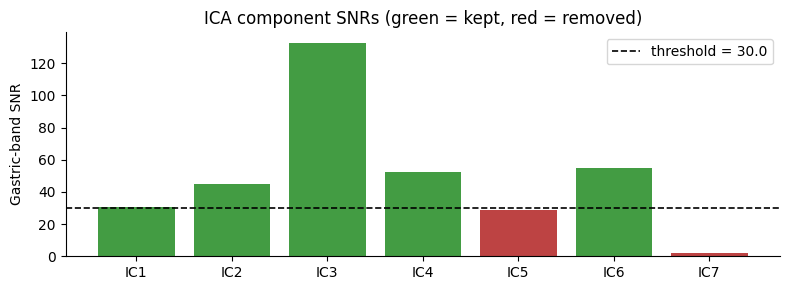

In [12]:
# Visualise ICA component SNRs with threshold line
fig, ax = plt.subplots(figsize=(8, 3))
x    = np.arange(len(snrs))
cols = ["forestgreen" if s >= ica_info["snr_threshold"] else "firebrick"
        for s in snrs]
ax.bar(x, snrs, color=cols, alpha=0.85)
ax.axhline(ica_info["snr_threshold"], color="black", lw=1.2, ls="--",
           label=f"threshold = {ica_info['snr_threshold']}")
ax.set_xticks(x)
ax.set_xticklabels([f"IC{i+1}" for i in x])
ax.set_ylabel("Gastric-band SNR")
ax.set_title("ICA component SNRs (green = kept, red = removed)")
ax.legend()
for spine in ("top", "right"):
    ax.spines[spine].set_visible(False)
plt.tight_layout()
plt.show()

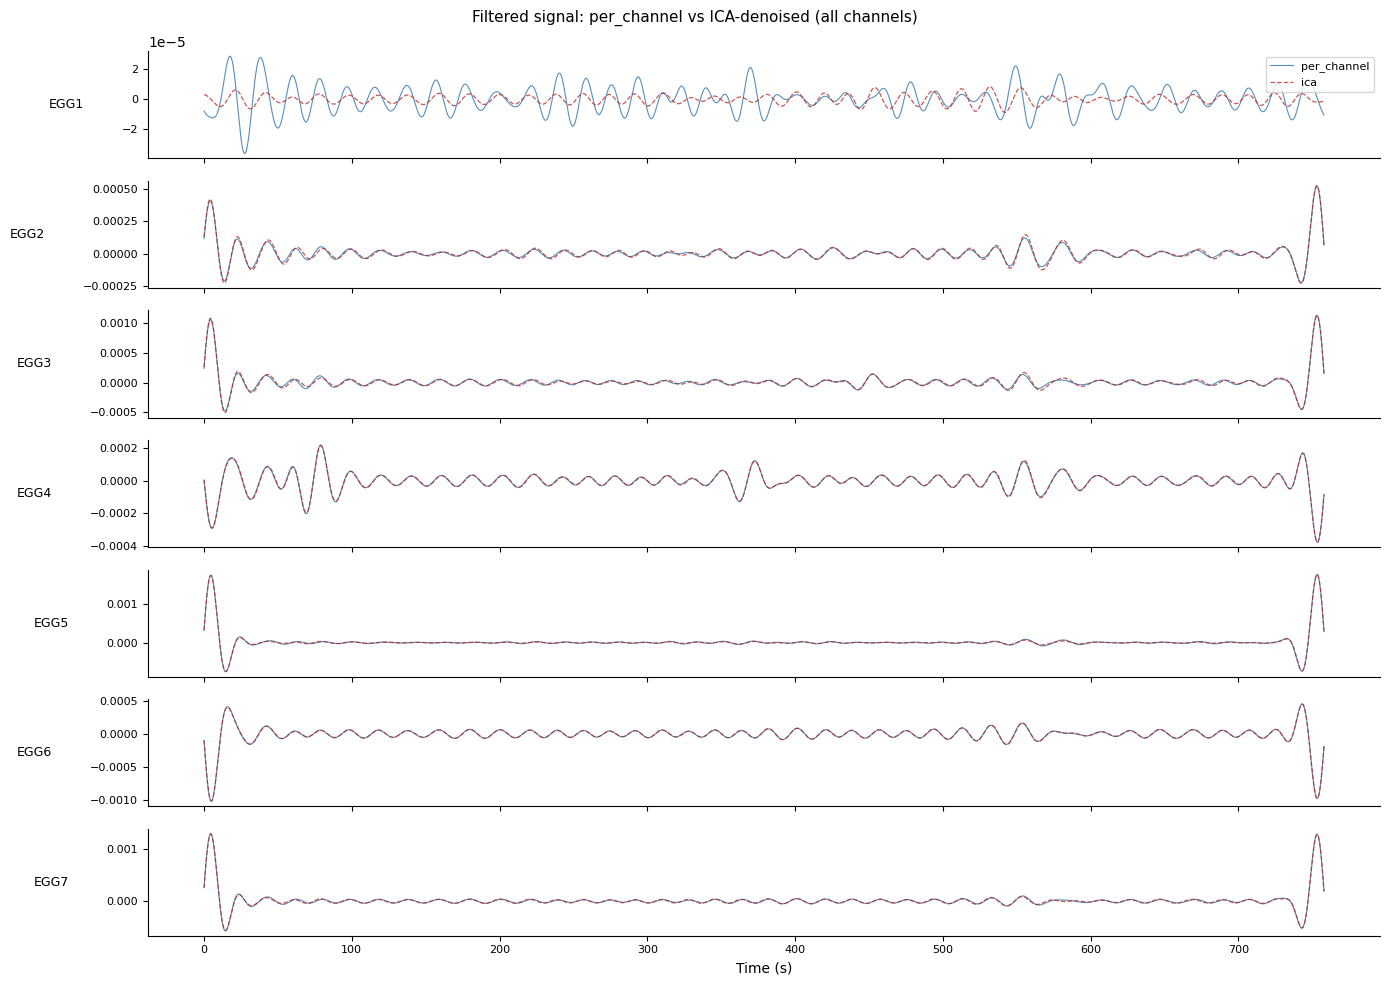

In [13]:
# Compare per_channel vs ICA-denoised filtered trace for every channel
fig, axes = plt.subplots(n_ch, 1, figsize=(14, 10), sharex=True)

for i, (ax, name, color) in enumerate(zip(axes, ch_names, colors)):
    per_filtered = result_per["channels"][i][0]["filtered"].values
    ica_filtered = result_ica["channels"][i][0]["filtered"].values

    ax.plot(times, per_filtered, lw=0.8, color="steelblue",   alpha=0.9,
            label="per_channel")
    ax.plot(times, ica_filtered, lw=0.9, color="firebrick", alpha=0.75,
            label="ica", ls="--")
    ax.set_ylabel(name, rotation=0, labelpad=40, va="center", fontsize=9)
    ax.tick_params(labelsize=8)
    for spine in ("top", "right"):
        ax.spines[spine].set_visible(False)

axes[0].legend(loc="upper right", fontsize=8)
axes[-1].set_xlabel("Time (s)")
fig.suptitle("Filtered signal: per_channel vs ICA-denoised (all channels)",
             fontsize=11)
fig.tight_layout()
plt.show()

## 4. Comparing Methods

Now we compare the three methods quantitatively.

Two questions:
1. **Do the estimated peak frequencies agree across methods?**
   High agreement suggests the gastric rhythm estimate is robust.
2. **Does ICA change the stability and rhythmicity metrics?**
   Meaningful changes indicate that component removal has attenuated
   non-gastric artefacts, sharpening the signal.

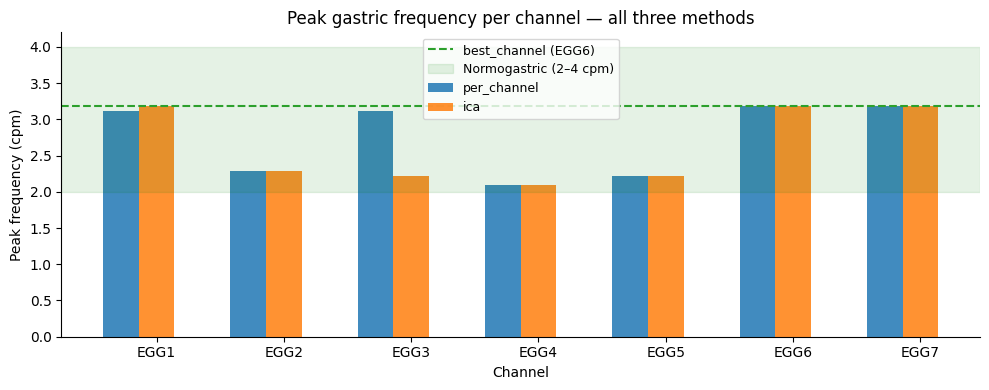

In [14]:
fig, ax = plt.subplots(figsize=(10, 4))

x = np.arange(n_ch)
w = 0.28

peak_per = result_per["summary"]["peak_freq_hz"].values * 60
peak_ica = result_ica["summary"]["peak_freq_hz"].values * 60

ax.bar(x - w, peak_per, width=w, label="per_channel", color="#1f77b4", alpha=0.85)
ax.bar(x,      peak_ica, width=w, label="ica",         color="#ff7f0e", alpha=0.85)
ax.axhline(result_best["info"]["peak_freq_hz"] * 60, color="#2ca02c",
           lw=1.5, ls="--",
           label=f"best_channel ({ch_names[result_best['info']['best_channel_idx']]})")

ax.axhspan(2, 4, alpha=0.1, color="green", label="Normogastric (2–4 cpm)")
ax.set_xticks(x)
ax.set_xticklabels(ch_names)
ax.set_xlabel("Channel")
ax.set_ylabel("Peak frequency (cpm)")
ax.set_title("Peak gastric frequency per channel — all three methods")
ax.legend(fontsize=9)
for spine in ("top", "right"):
    ax.spines[spine].set_visible(False)
plt.tight_layout()
plt.show()

In [15]:
import pandas as pd

# Build a side-by-side comparison table for all channels
rows = []
for i, name in enumerate(ch_names):
    per_info = result_per["channels"][i][1]
    ica_info_ch = result_ica["channels"][i][1]
    rows.append({
        "channel":        name,
        "IC (per_ch)":    per_info["instability_coefficient"],
        "IC (ica)":       ica_info_ch["instability_coefficient"],
        "normo% (per_ch)": per_info["proportion_normogastric"],
        "normo% (ica)":   ica_info_ch["proportion_normogastric"],
        "peak Hz (per_ch)": per_info["peak_freq_hz"],
        "peak Hz (ica)":  ica_info_ch["peak_freq_hz"],
    })

comparison = pd.DataFrame(rows)
print("Method comparison — instability coefficient, proportion normogastric, peak frequency:")
print(comparison.to_string(index=False, float_format="{:.4g}".format))

Method comparison — instability coefficient, proportion normogastric, peak frequency:
channel  IC (per_ch)  IC (ica)  normo% (per_ch)  normo% (ica)  peak Hz (per_ch)  peak Hz (ica)
   EGG1       0.2115   0.09653           0.9211        0.9737             0.052          0.053
   EGG2       0.3477    0.2487           0.8889        0.8947             0.038          0.038
   EGG3       0.3595    0.3323           0.9143        0.9143             0.052          0.037
   EGG4       0.1422    0.1441                1             1             0.035          0.035
   EGG5        1.408     1.389            0.913        0.7222             0.037          0.037
   EGG6       0.1759    0.1766           0.9459        0.9459             0.053          0.053
   EGG7       0.7241    0.7563           0.9355           0.9             0.053          0.053


### When to use each strategy

| Strategy | Use when |
|---|---|
| `"per_channel"` | You want a quality overview of all electrodes; useful for QC, identifying bad channels, or summarising a group study |
| `"best_channel"` | You need a single-channel result with minimal configuration; equivalent to `select_best_channel` + `egg_process` |
| `"ica"` | Your recording has coherent spatial noise (ambulatory subjects, high-motion environments); short or very clean lab recordings see minimal benefit |

> **Note on this dataset:** The Wolpert et al. (2020) recording is a clean
> laboratory acquisition — participants were seated and fasted. ICA with
> the default `snr_threshold=3.0` removes only 1 of 7 components (SNR=2.33),
> producing negligible changes to the metrics. For ambulatory recordings,
> the effect is typically much larger. We used `snr_threshold=30.0` in
> cells above solely to illustrate what component removal looks like.

## 5. Sine Fitting

Once we have a clean, bandpass-filtered gastric signal, `fit_sine` fits a
sinusoidal model `A · sin(2πft + φ)` using L-BFGS-B least-squares
optimisation (Dalmaijer, 2025).

**Why fit a sine?**

- Provides a single *amplitude* estimate that is more robust than the
  envelope from the Hilbert transform for short recordings.
- Gives a precise *phase offset* φ, directly interpretable for
  gastric–brain coupling experiments (e.g., aligning EEG epochs to the
  gastric phase at stimulus onset).
- The *residual* quantifies how well the gastric rhythm approximates a
  pure sinusoid — useful as an additional quality metric.

In [16]:
# Use the ICA-denoised, filtered best channel
best_ica_filtered = result_ica["channels"][best_idx][0]["filtered"].values

# Fit with the known peak frequency locked in (faster, more stable)
sine_result = gp.fit_sine(best_ica_filtered, sfreq=sfreq, freq=peak_freq_hz)

print(f"Fitted to channel   : {ch_names[best_idx]}")
print(f"Fixed frequency     : {sine_result['freq_hz']:.4f} Hz  "
      f"({sine_result['freq_hz'] * 60:.2f} cpm)")
print(f"Fitted amplitude    : {sine_result['amplitude']:.6f}")
print(f"Fitted phase offset : {sine_result['phase_rad']:.4f} rad  "
      f"({np.degrees(sine_result['phase_rad']):.1f}°)")
print(f"Residual (SS)       : {sine_result['residual']:.4e}")

Fitted to channel   : EGG6
Fixed frequency     : 0.0530 Hz  (3.18 cpm)
Fitted amplitude    : 0.000030
Fitted phase offset : -0.0000 rad  (-0.0°)
Residual (SS)       : 1.4294e-04


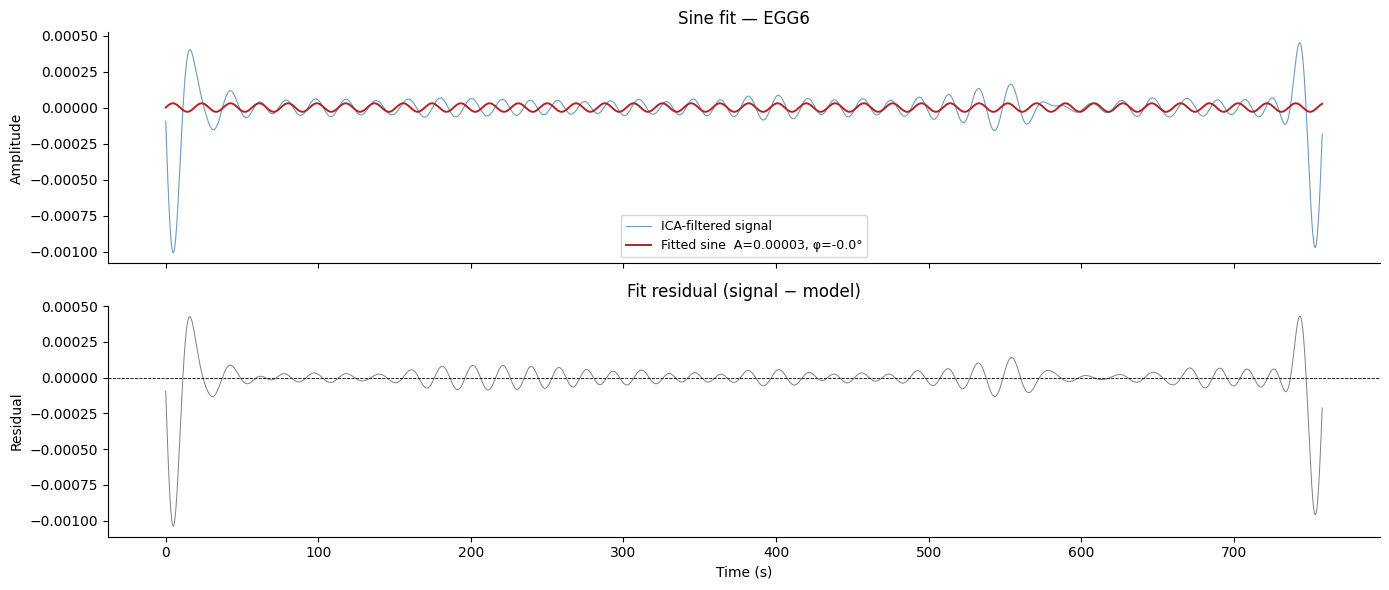

In [17]:
t_vec     = np.arange(len(best_ica_filtered)) / sfreq
fitted    = gp.sine_model(t_vec,
                          freq=sine_result["freq_hz"],
                          phase=sine_result["phase_rad"],
                          amp=sine_result["amplitude"])
residual  = best_ica_filtered - fitted

fig, axes = plt.subplots(2, 1, figsize=(14, 6), sharex=True)

axes[0].plot(t_vec, best_ica_filtered, lw=0.8, color="steelblue",
             alpha=0.8, label="ICA-filtered signal")
axes[0].plot(t_vec, fitted, lw=1.4, color="firebrick",
             label=f"Fitted sine  A={sine_result['amplitude']:.5f}, "
                   f"φ={np.degrees(sine_result['phase_rad']):.1f}°")
axes[0].set_ylabel("Amplitude")
axes[0].set_title(f"Sine fit — {ch_names[best_idx]}")
axes[0].legend(fontsize=9)

axes[1].plot(t_vec, residual, lw=0.7, color="dimgrey", alpha=0.85)
axes[1].axhline(0, color="black", lw=0.6, ls="--")
axes[1].set_ylabel("Residual")
axes[1].set_xlabel("Time (s)")
axes[1].set_title("Fit residual (signal − model)")

for ax in axes:
    for spine in ("top", "right"):
        ax.spines[spine].set_visible(False)

plt.tight_layout()
plt.show()

## Summary

This tutorial covered the complete multi-channel EGG analysis pipeline:

### Workflow recap

| Step | Function | Key output |
|---|---|---|
| Load data | `gp.load_egg()` | `signal` (n_ch, n_samp) |
| Channel quality | `gp.select_best_channel()` | `best_idx`, `peak_freq_hz` |
| PSD visualisation | `gp.psd_welch()` + `gp.plot_psd()` | PSD plot |
| Spike removal | `gp.hampel_filter()` | Spike-free signal |
| Movement filtering | `gp.remove_movement_artifacts()` | Motion-corrected signal |
| Robust cleaning | `gp.egg_clean(method="dalmaijer2025")` | Fully preprocessed signal |
| All-channel processing | `gp.egg_process_multichannel(method="per_channel")` | Summary DataFrame |
| Optimal-channel processing | `gp.egg_process_multichannel(method="best_channel")` | `egg_process` result |
| Spatial denoising | `gp.egg_process_multichannel(method="ica")` | ICA-denoised metrics |
| Sine characterisation | `gp.fit_sine()` | Amplitude, phase, residual |

### References

- Dalmaijer, E. S. (2025). *electrography* v1.1.1.
  https://github.com/esdalmaijer/electrography
- Gharibans, A. A., et al. (2018). Artifact rejection methodology enables
  continuous, noninvasive measurement of gastric myoelectric activity in
  ambulatory subjects. *Scientific Reports*, 8, 5019.
  https://doi.org/10.1038/s41598-018-23302-9
- Wolpert, N., Rebollo, I., & Tallon-Baudry, C. (2020). Electrogastrography
  for psychophysiological research: Practical considerations, analysis
  pipeline, and normative data in a large sample. *Psychophysiology*, 57,
  e13599. https://doi.org/10.1111/psyp.13599

---

**See also:**
[EGG Processing Tutorial](egg_processing.ipynb),
[Artifact Removal](../examples/artifact_removal.ipynb),
[Multi-Channel Example](../examples/multichannel_processing.ipynb),
[Gastric–Brain Coupling Tutorial](gastric_brain_coupling.ipynb)